c:\Users\adfa01\.conda\envs\cadet_workshop\Lib\site-packages\CADETProcess\processModel\unitOperation.py:396: UserWarning: Detected Bulk Reaction Model. Attempt casting to Particle Reaction Model.
  warnings.warn(


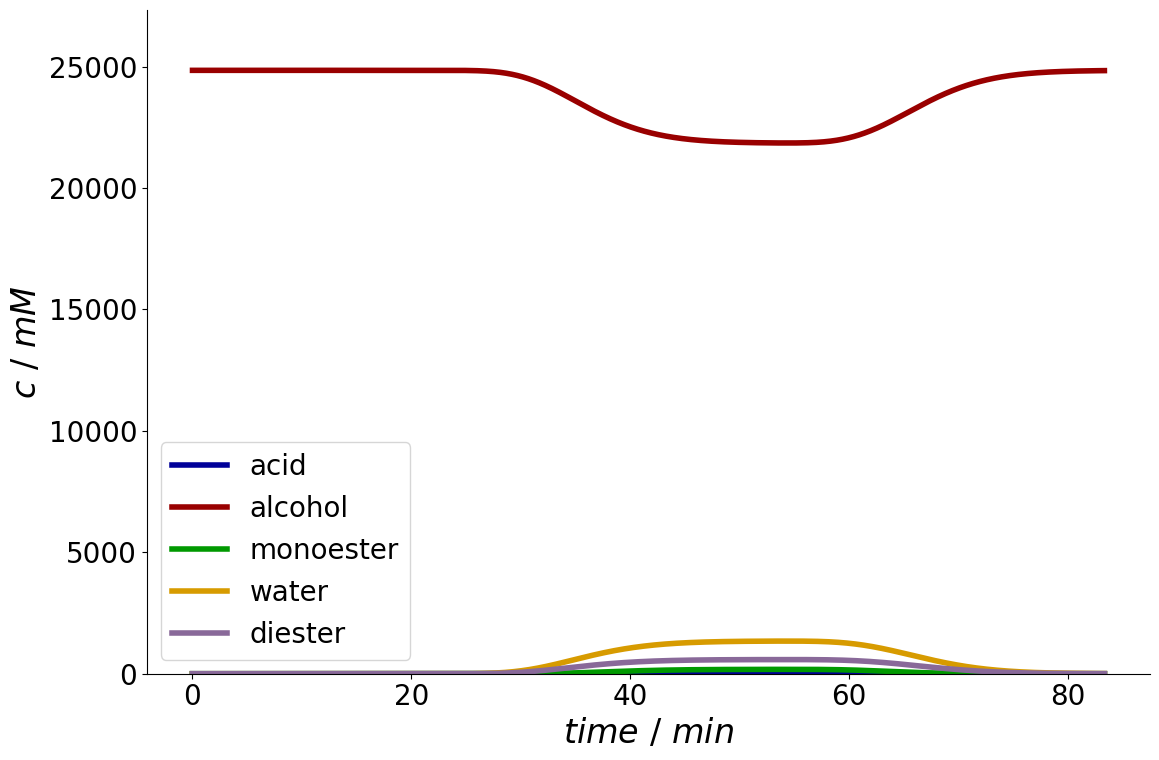

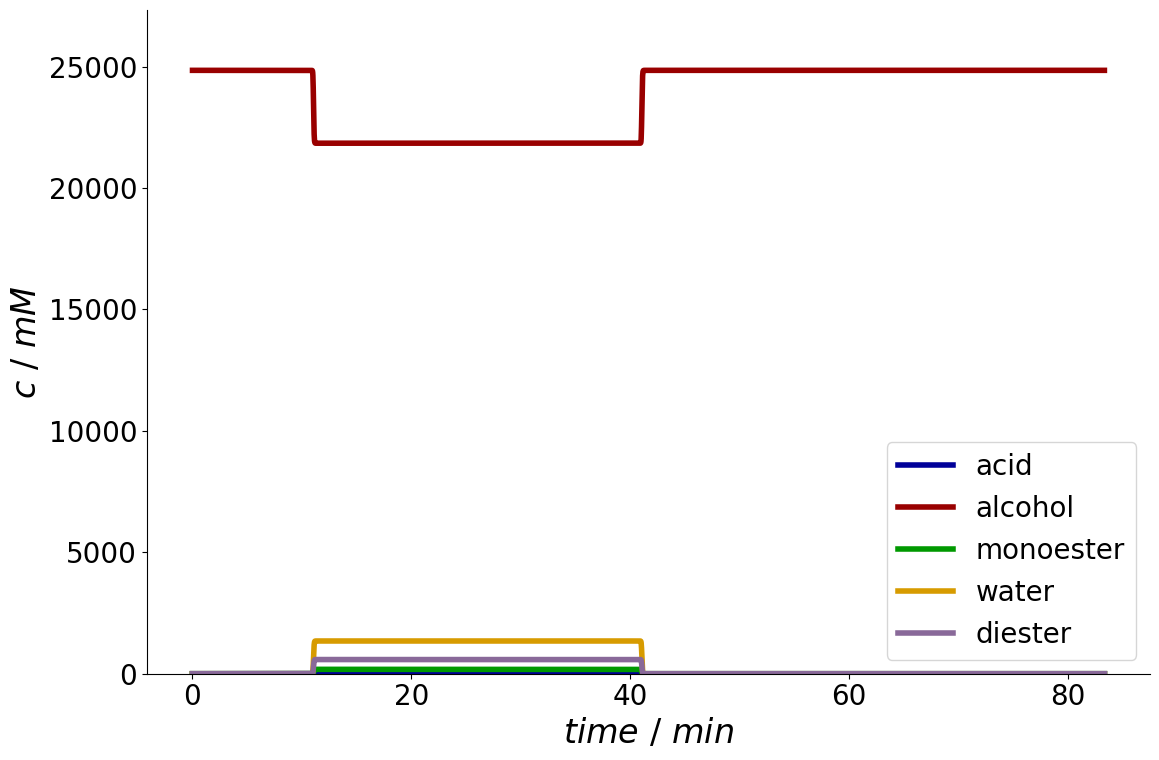

In [ ]:
from CADETProcess.processModel import ComponentSystem, MassActionLaw,Langmuir #Für Solid MassActionLawParticle
from CADETProcess.processModel import Process
from CADETProcess.processModel import Inlet, Outlet, LumpedRateModelWithoutPores
from CADETProcess.processModel import FlowSheet
from CADETProcess.simulator import Cadet
%matplotlib inline

def create_column(component_system):
    column = LumpedRateModelWithoutPores(component_system, name="column")
    column.length = 0.215
    column.total_porosity = 0.6171
    column.diameter = 0.016
    column.axial_dispersion = 5.36649151e-07
    return column

def create_flow_sheet(component_system, flow_rate):
    reaction_system = MassActionLaw(component_system)
    reaction_system.add_reaction(        #für Solid reaction_system.add_solid_reaction
        indices=[0, 1 , 2, 3, 4],
        coefficients=[-1, -1, 1, 1, 0],
        k_fwd=0.09,
        k_bwd=0.05
    )
    reaction_system.add_reaction(
        indices=[0, 1 , 2, 3, 4],
        coefficients=[0, -1, -1, 1, 1],
        k_fwd=0.01,
        k_bwd=0.05
    )

    #binding model
    binding_model = Langmuir(component_system, name='LANGMUIR')
    binding_model.is_kinetic = True
    binding_model.adsorption_rate = [1, 0.01, 0.01,0.01,0.01]
    binding_model.desorption_rate = [0.01, 0.01, 0.01, 0.01, 0.01]
    binding_model.capacity = [1, 0.01, 0.01, 0.01, 0.01]
    
    #connect column to reaction and binding model
    column = create_column(component_system)
    column.binding_model = binding_model
    column.particle_reaction_model = reaction_system
    column.c = [0, 24846, 0, 0, 0]
    #flow sheet
    flow_sheet = FlowSheet(component_system)
    #define units
    inlet = Inlet(component_system, name='inlet')
    inlet.flow_rate = flow_rate  #m^3/s == 1 ml/min 1.67e-8
    outlet = Outlet(component_system, name= 'out')
    #add units
    flow_sheet.add_unit(column)
    flow_sheet.add_unit(inlet)
    flow_sheet.add_unit(outlet)
    #connect units
    flow_sheet.add_connection(inlet,column)
    flow_sheet.add_connection(column,outlet)
    return flow_sheet

#define process
def create_breakthrough_process(experiment_id, component_system, flow_rate, load_acid, load_alcohol, load_monoester, load_water, load_diester):
    flow_sheet = create_flow_sheet(component_system, flow_rate)
    #process = Process(flow_sheet, 'process')
    process = Process(flow_sheet, f"experiment {experiment_id}")
    process.cycle_time = 5000
    process.add_event('load', 'flow_sheet.inlet.c', [load_acid, load_alcohol, load_monoester, load_water, load_diester], 600)
    process.add_event('desorb', 'flow_sheet.inlet.c', [0, 24846, 0, 0, 0], 2400)
    return process

component_system = ComponentSystem(['acid', 'alcohol', 'monoester', 'water', 'diester'])

process_flow1 = create_breakthrough_process("process_flow1", component_system, 1.67e-8, 770, 23193, 0, 0 ,0 )
process_flow2 = create_breakthrough_process("process_flow2",component_system, 4.17e-7, 770, 23193, 0, 0 ,0 )


simulator = Cadet()
simulator.time_resolution = 1

sim_results = simulator._run(process_flow1)
_ = sim_results.solution.out.outlet.plot()

sim_results = simulator._run(process_flow2)
_ = sim_results.solution.out.outlet.plot()



(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='$time~/~min$', ylabel='$c~/~mM$'>)

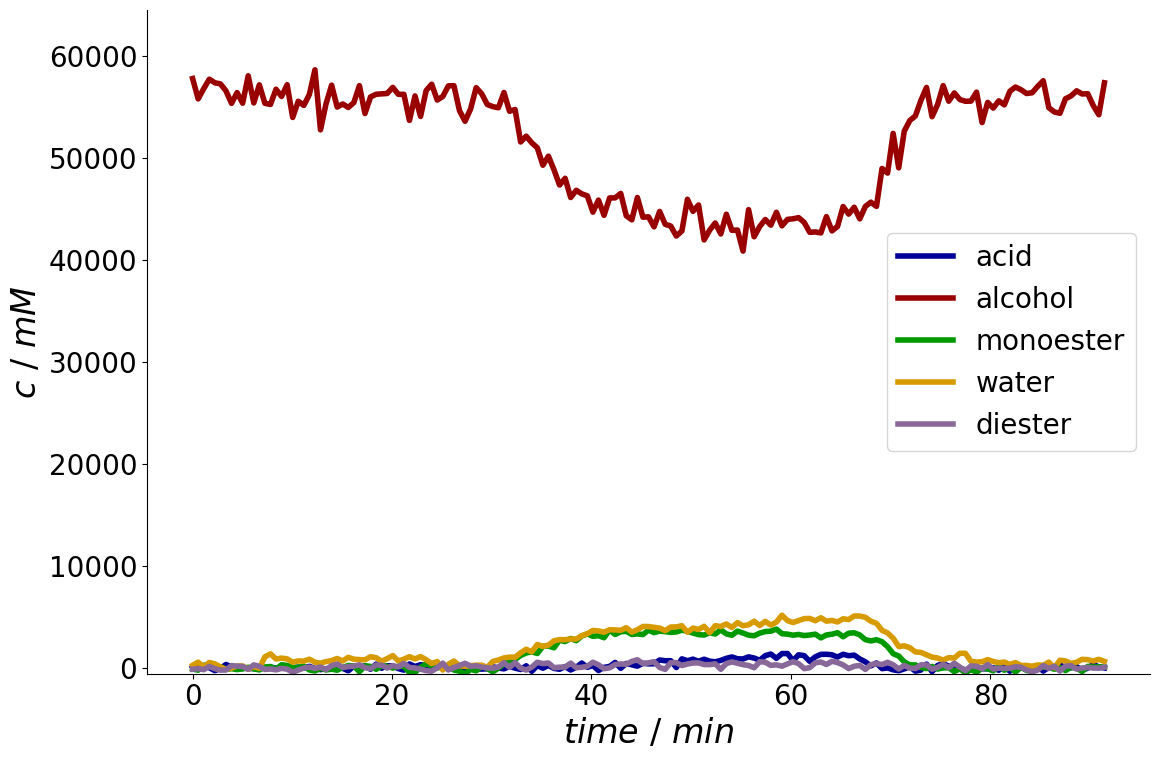

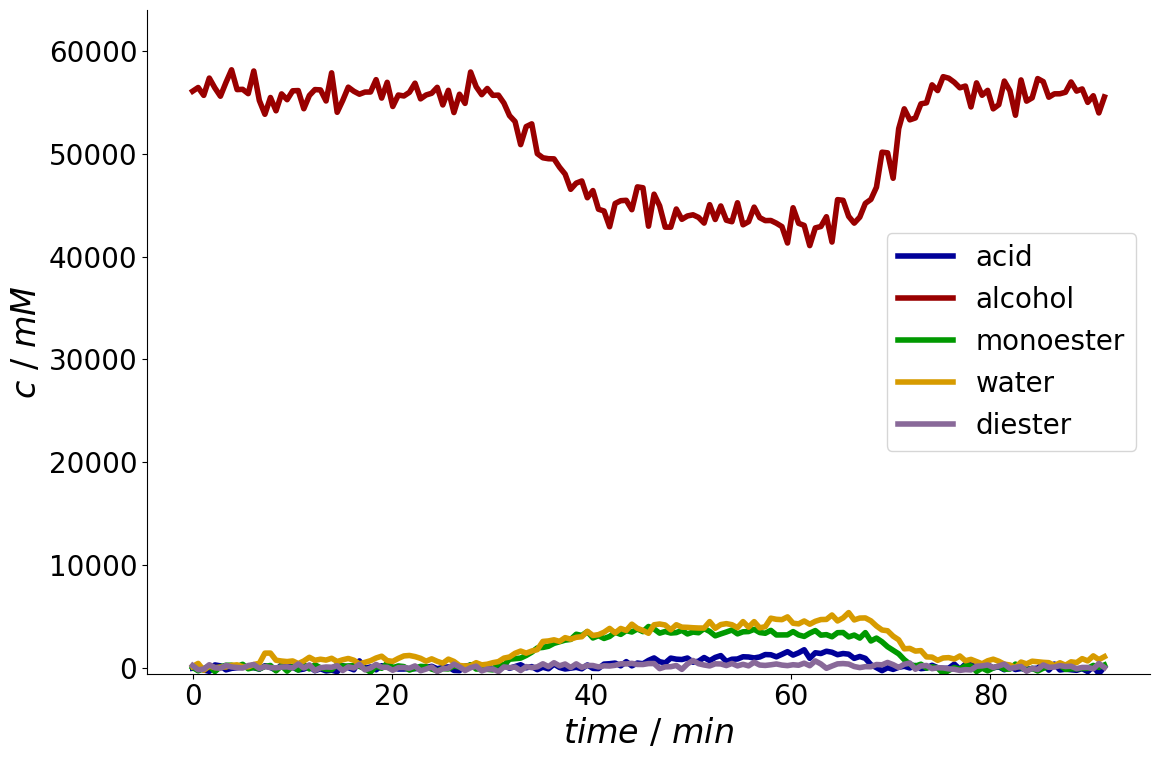

In [ ]:
#load and plot reference

import pandas as pd
data1 = pd.read_excel("example_data_1.xlsx", index_col=0, usecols=range(6))
data2 = pd.read_excel("example_data_2.xlsx", index_col=0, usecols=range(6))

from CADETProcess.reference import ReferenceIO

flowrate1 = pd.read_excel("example_data_1.xlsx",usecols=["flowrate"]) #flowrate in m^3/s
flowrate2 = pd.read_excel("example_data_2.xlsx",usecols=["flowrate"])
reference_1 = ReferenceIO('reference_1', data1.index, data1, flowrate1 , component_system= component_system ) 
reference_2 = ReferenceIO('reference_2', data2.index, data2, flowrate2 , component_system= component_system ) 

reference_1.plot()
reference_2.plot()


experiment process_flow1


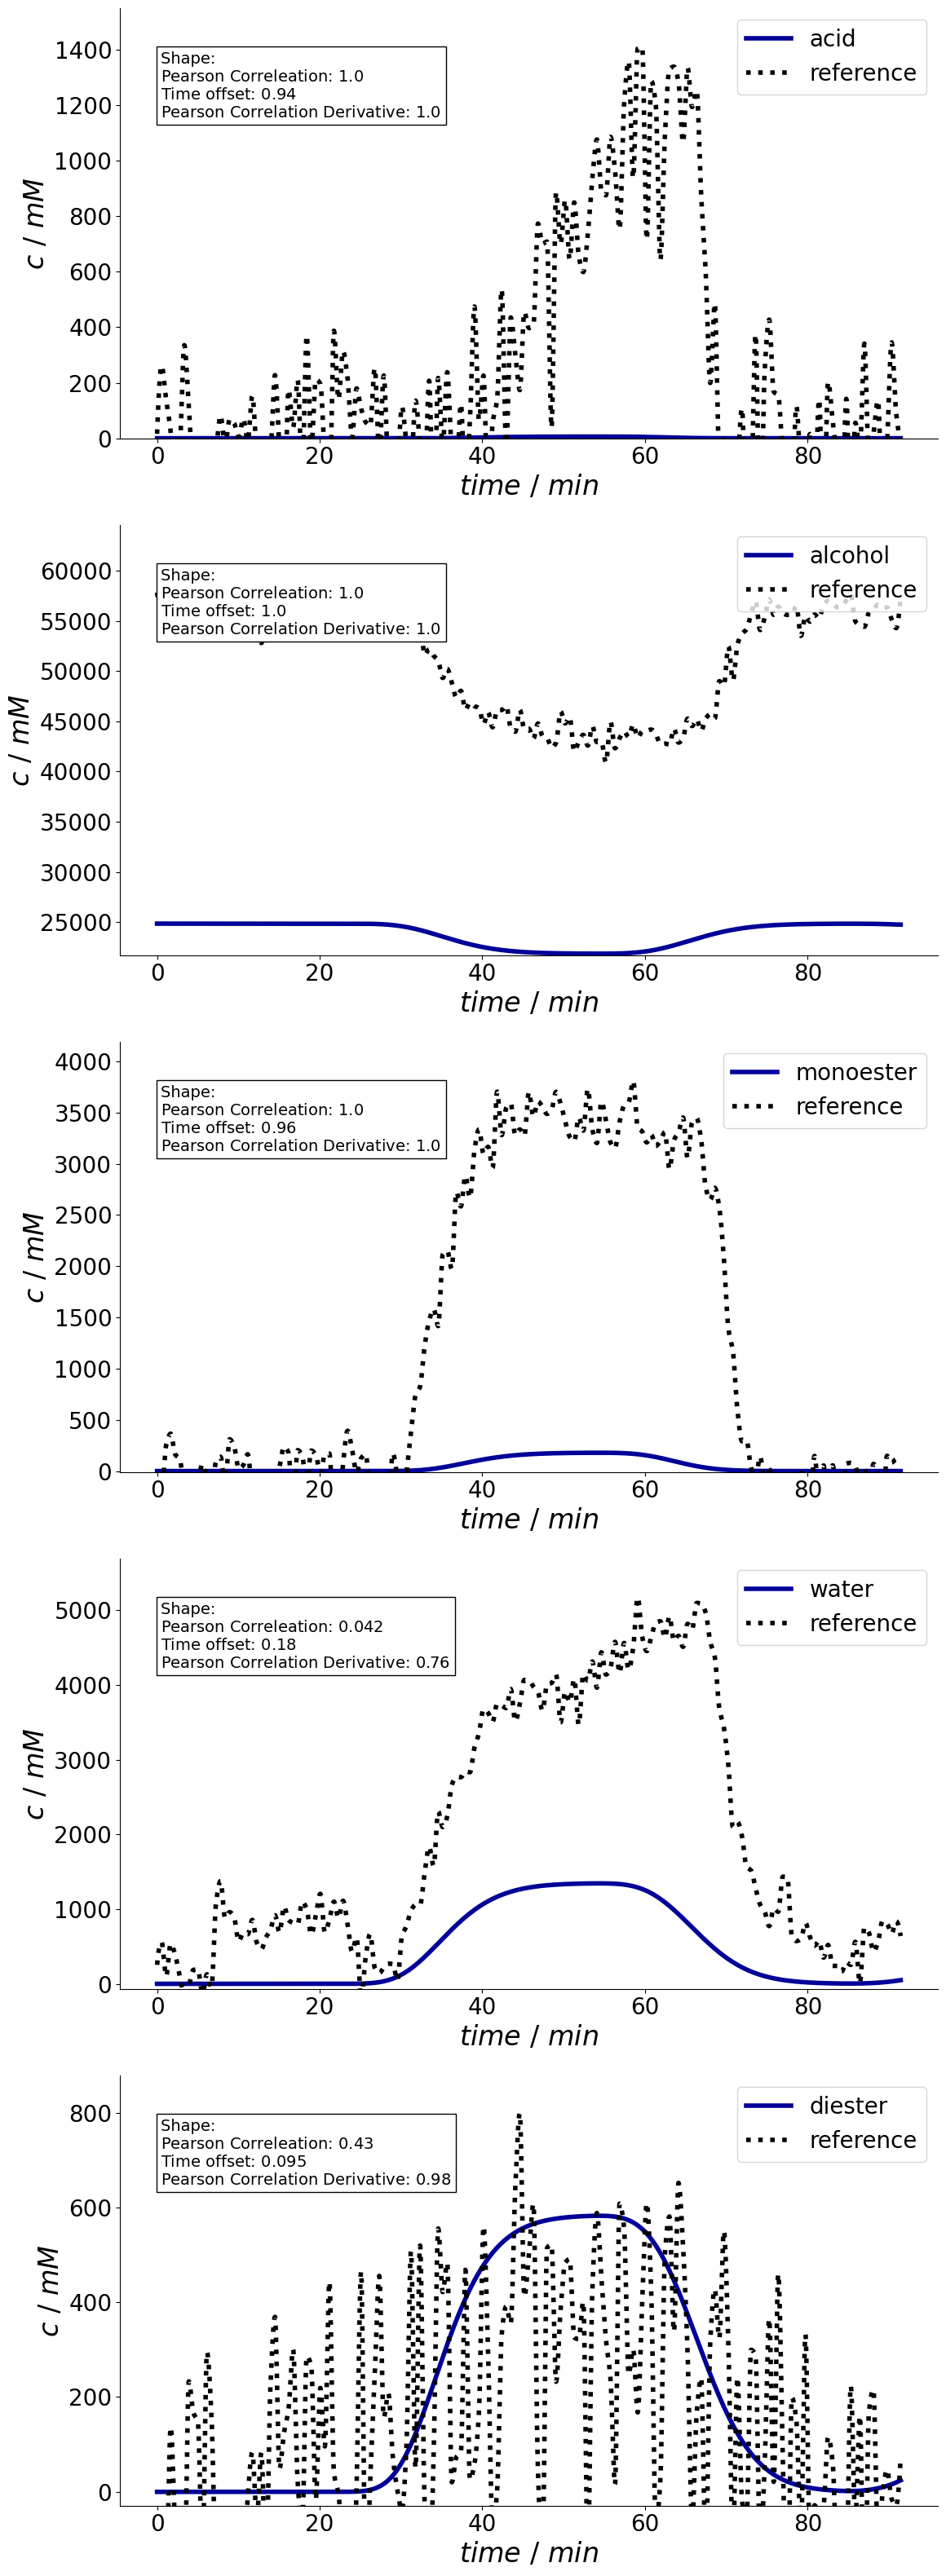

experiment process_flow2


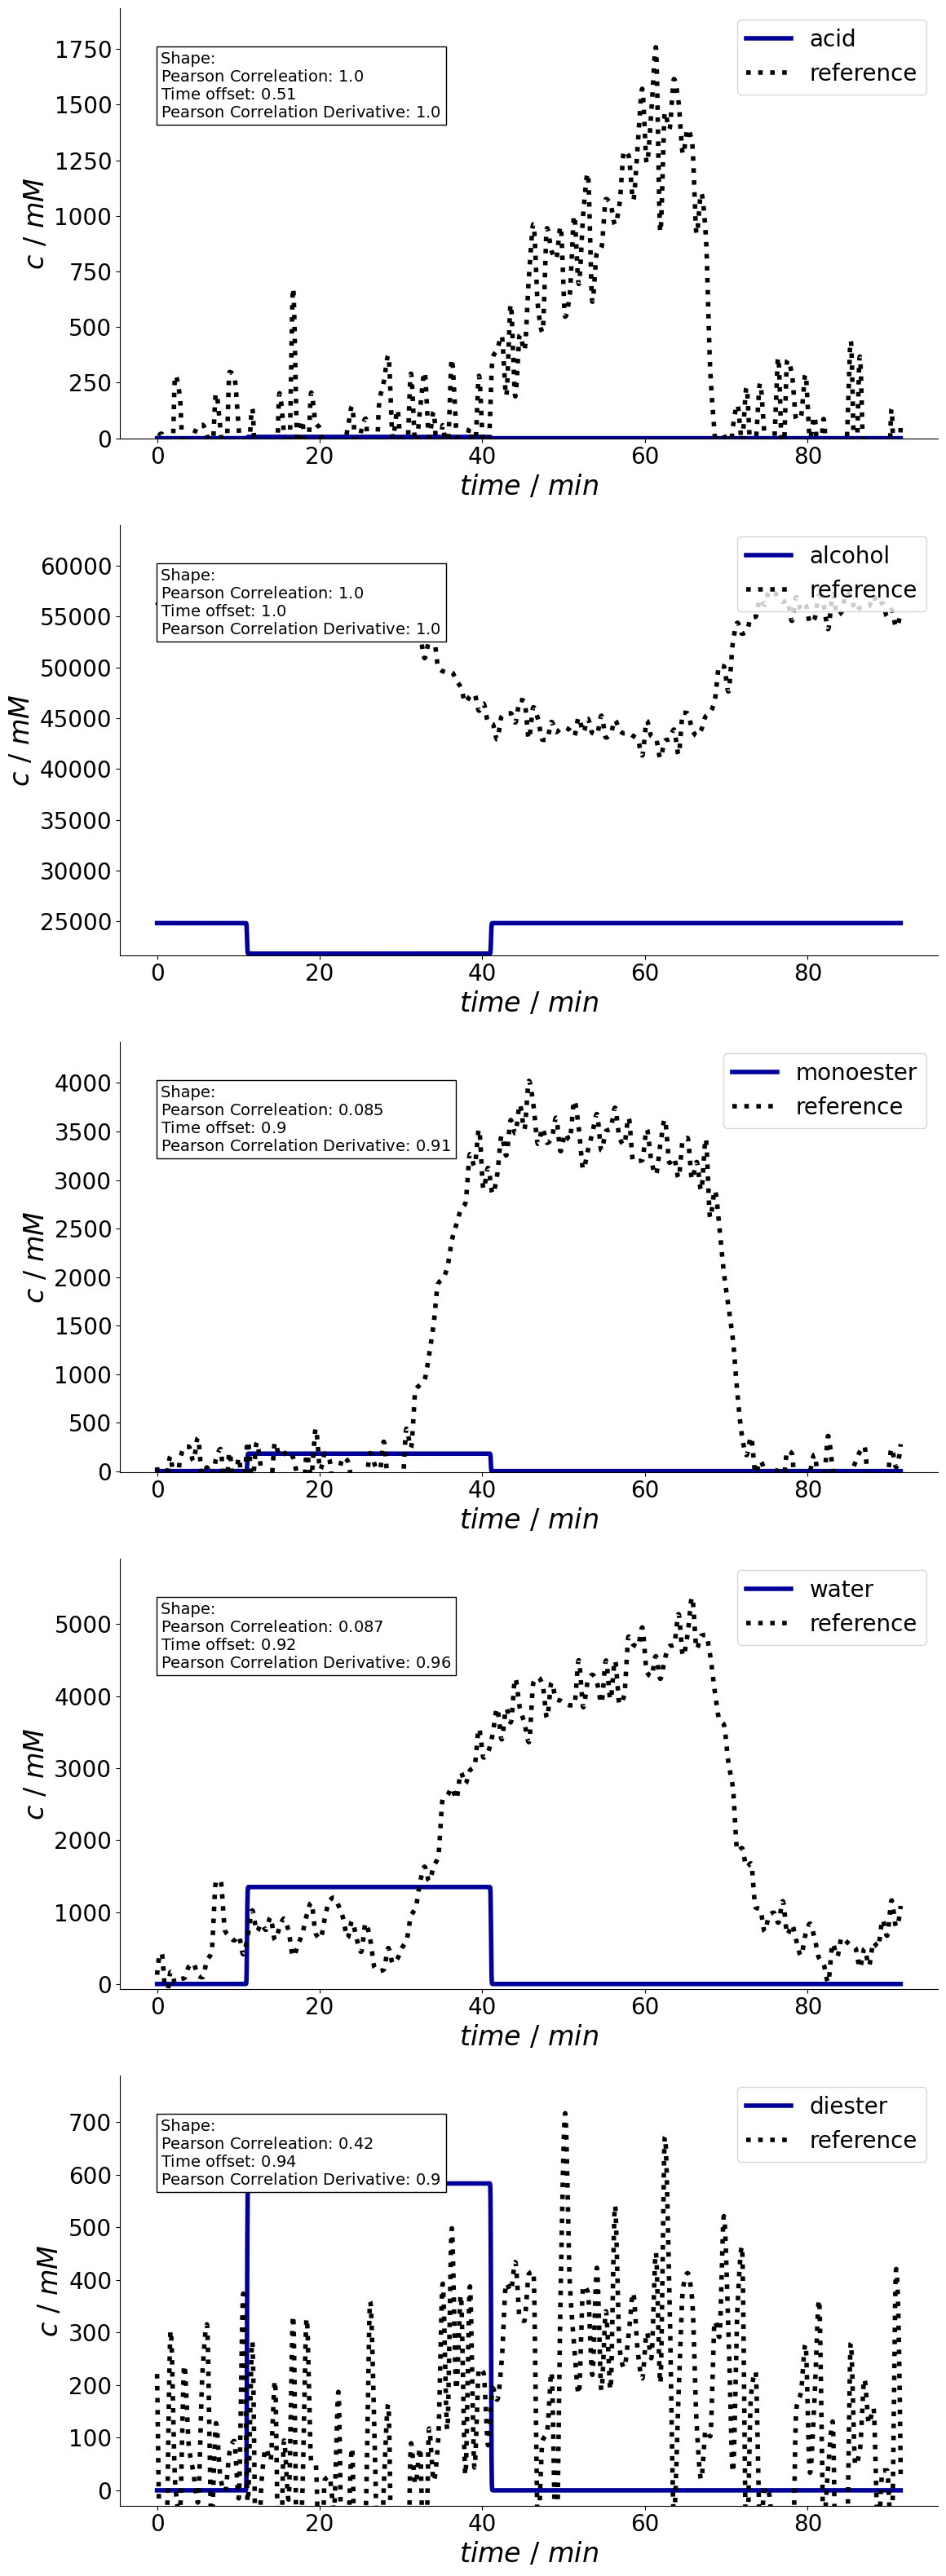

In [ ]:
#compare simulation to reference

from CADETProcess.comparison import Comparator
from CADETProcess.optimization import OptimizationProblem

optimization_problem = OptimizationProblem('react chrom')
optimization_problem.add_evaluator(simulator)

for process, reference in zip([process_flow1, process_flow2], [reference_1, reference_2]):
    comparator = Comparator(name=reference.name)

    comparator.add_reference(reference)

    comparator.add_difference_metric('Shape', reference, 'column.outlet', components=["acid"])
    comparator.add_difference_metric('Shape', reference, 'column.outlet', components=["alcohol"])
    comparator.add_difference_metric('Shape', reference, 'column.outlet', components=["monoester"])
    comparator.add_difference_metric('Shape', reference, 'column.outlet', components=["water"])
    comparator.add_difference_metric('Shape', reference, 'column.outlet', components=["diester"])

    optimization_problem.add_evaluation_object(process)
    print(process)

    optimization_problem.add_objective(
        comparator,
        name=f"Objective {comparator.name}",
        evaluation_objects=[process],  # limit this comparator to be applied to only this one process
        n_objectives=comparator.n_metrics,
        requires=[simulator]


    )

    simulation_results = simulator.simulate(process)
    comparator.plot_comparison(simulation_results)

In [29]:
def callback(simulation_results, individual, evaluation_object, callbacks_dir='./'):
    comparator.plot_comparison(
        simulation_results,
        file_name=f'{callbacks_dir}/{individual.id}_{evaluation_object}_comparison.png',
        show=False
    )

optimization_problem.add_callback(callback, requires=[simulator])

In [ ]:
optimization_problem.add_variable(
    name='axial_dispersion', parameter_path='flow_sheet.column.axial_dispersion',
    lb=1e-9, ub=1e-6,
    transform='auto'
    )

for component_i in range(4):
    optimization_problem.add_variable(
    name= f"adsorption_rate{component_i}", 
    parameter_path='flow_sheet.column.binding_model.adsorption_rate',
    lb=1e-2, ub=10,
    transform='auto',
    indices = [component_i]
    )
    

    optimization_problem.add_variable(
    name= f"desorption_rate{component_i}", 
    parameter_path='flow_sheet.column.binding_model.desorption_rate',
    lb=1e-2, ub=10,
    transform='auto',
    indices = [component_i]
    )

    optimization_problem.add_variable(
    name= f"capacity{component_i}", 
    parameter_path='flow_sheet.column.binding_model.capacity',
    lb=1e-2, ub=10,
    transform='auto',
    indices = [component_i]
    )



In [ ]:
optimization_problem.add_variable(
    name='k_fwd',parameter_path= "flow_sheet.column.particle_reaction_model.k_fwd_liquid",
    lb=1e-9, ub=1e-6,
    transform='auto'
    )
optimization_problem.add_variable(
    name='k_bwd',parameter_path= "flow_sheet.column.particle_reaction_model.k_bwd_liquid",
    lb=1e-9, ub=1e-6,
    transform='auto'
    )


OptimizationVariable(name=k_bwd, evaluation_objects=['experiment process_flow1', 'experiment process_flow2'], parameter_path=flow_sheet.column.particle_reaction_model.k_bwd_liquid, lb=1e-09, ub=1e-06)

In [32]:
from CADETProcess.optimization import U_NSGA3
optimizer = U_NSGA3()
optimizer.n_cores = 8
optimizer.pop_size = 32
optimizer.n_max_gen = 8

In [33]:
optimization_results = optimizer.optimize(
        optimization_problem,
        use_checkpoint=False
    )

TypeError: ProxyList.__init__() missing 1 required positional argument: 'instance'

In [ ]:
print(optimization_results.x)
#print(optimization_results.f)


[[5.36649151e-07]
 [5.99520593e-07]]
